In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/Heart_sounds.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory

In [ ]:


# Config
SAMPLE_RATE = 16000
FIXED_DURATION = 15  # seconds
FIXED_LENGTH = SAMPLE_RATE * FIXED_DURATION  # samples (240000)

def preprocess_audio_to_spectrogram(wav_path):
    y, _ = librosa.load(wav_path, sr=SAMPLE_RATE, mono=True)

    # Zero pad or truncate
    if len(y) < FIXED_LENGTH:
        padding = FIXED_LENGTH - len(y)
        y = np.pad(y, (0, padding), mode='constant')
    else:
        y = y[:FIXED_LENGTH]

    # Convert to Mel spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=SAMPLE_RATE, n_mels=128)
    S_DB = librosa.power_to_db(S, ref=np.max)

    # Normalize between 0 and 1
    S_DB = (S_DB - S_DB.min()) / (S_DB.max() - S_DB.min())

    # Add channel dimension (H, W, 1)
    # Make it ready for CNN
    S_DB = np.expand_dims(S_DB, axis=-1)

    return S_DB

def save_spectrogram_image(spec, output_path):
    plt.figure(figsize=(3, 3))
    plt.imshow(spec[:, :, 0], aspect='auto', origin='lower', cmap='viridis')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close()

# Process all files
for split in ['train', 'val']:
    input_root = f'/content/heart_sound/{split}'
    output_root = f'/content/images_1/{split}'

    for label in ['healthy', 'unhealthy']:
        input_folder = os.path.join(input_root, label)
        output_folder = os.path.join(output_root, label)
        os.makedirs(output_folder, exist_ok=True)

        for file_name in os.listdir(input_folder):
            if file_name.endswith('.wav'):
                wav_path = os.path.join(input_folder, file_name)
                img_path = os.path.join(output_folder, file_name.replace('.wav', '.png'))

                spectrogram = preprocess_audio_to_spectrogram(wav_path)
                save_spectrogram_image(spectrogram, img_path)

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
# Config
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 500

In [ ]:
# Config
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 100

# Load Images Function (already written in your code)
def load_images(image_folder):
    images = []
    labels = []

    # Loop through subfolders (healthy, unhealthy) and load images
    for label in ['healthy', 'unhealthy']:
        label_folder = os.path.join(image_folder, label)
        for img_file in os.listdir(label_folder):
            if img_file.endswith('.png'):
                img_path = os.path.join(label_folder, img_file)
                # Load image and resize it to the fixed dimensions
                img = image.load_img(img_path, target_size=IMAGE_SIZE, color_mode='grayscale')
                img_array = image.img_to_array(img)  # Convert image to array
                images.append(img_array)
                labels.append(0 if label == 'healthy' else 1)  # Assign label (0 for healthy, 1 for unhealthy)

    return np.array(images), np.array(labels)


In [ ]:
# Load data
train_images, train_labels = load_images('/content/images_1/train')
valid_images, valid_labels = load_images('/content/images_1/val')


# Normalize the image pixel values to be between 0 and 1
train_images = train_images / 255.0
valid_images = valid_images / 255.0

# Reshape images to have the correct shape for the CNN (height, width, channels)
train_images = train_images.reshape(-1, 128, 128, 1)
valid_images = valid_images.reshape(-1, 128, 128, 1)

In [ ]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification: healthy (0) vs unhealthy (1)
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 126, 126, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 4, 16)       │        18,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 2, 2, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,289 (524.57 KB)

 Trainable params: 134,289 (524.57 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print("Training data size:")
print("Healthy:", len(os.listdir('/content/heart_sound/train/healthy')))
print("Unhealthy:", len(os.listdir('/content/heart_sound/train/unhealthy')))


Training data size:
Healthy: 2575
Unhealthy: 665


In [ ]:
from sklearn.utils import class_weight
import numpy as np

#making biased classes (balanced)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weights_dict)

Class Weights: {0: np.float64(0.629126213592233), 1: np.float64(2.43609022556391)}


In [ ]:
# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_images, train_labels,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(valid_images, valid_labels)
)

Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.7752 - loss: 0.5775 - val_accuracy: 0.4983 - val_loss: 0.8405
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8074 - loss: 0.5056 - val_accuracy: 0.4983 - val_loss: 0.8602
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7995 - loss: 0.5107 - val_accuracy: 0.4983 - val_loss: 0.8505
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7912 - loss: 0.5121 - val_accuracy: 0.4983 - val_loss: 0.9114
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7935 - loss: 0.5010 - val_accuracy: 0.4983 - val_loss: 0.7498
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7976 - loss: 0.4239 - val_accuracy: 0.6179 - val_loss: 0.7901
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8149 - loss: 0.3430 - val_accuracy: 0.5980 - val_loss: 0.6711
Epoch 8/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8163 - loss: 0.3314 - 

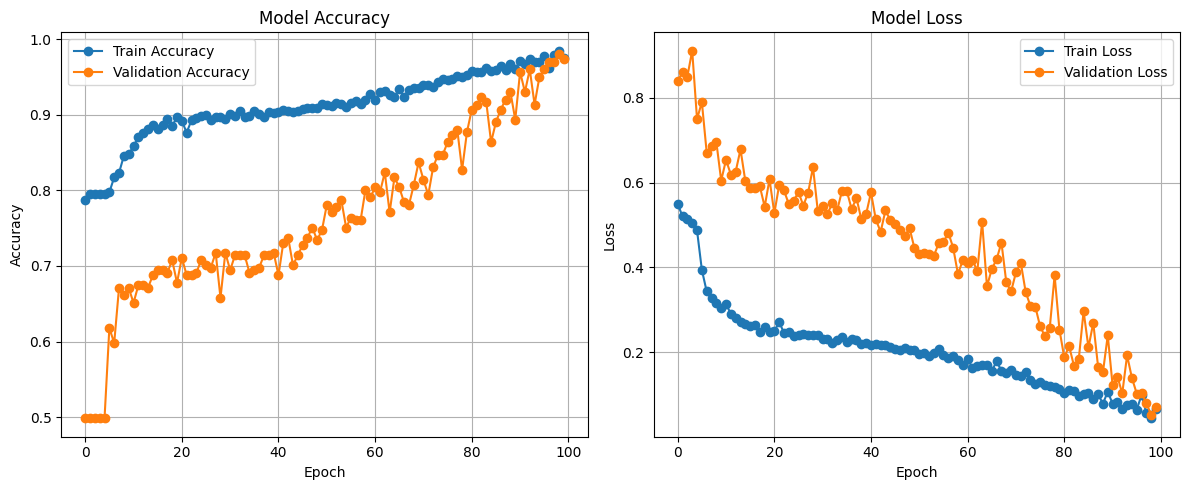

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Classification Report:

              precision    recall  f1-score   support

     Healthy       0.96      0.99      0.97       150
   Unhealthy       0.99      0.95      0.97       151

    accuracy                           0.97       301
   macro avg       0.97      0.97      0.97       301
weighted avg       0.97      0.97      0.97       301



<Figure size 600x600 with 0 Axes>

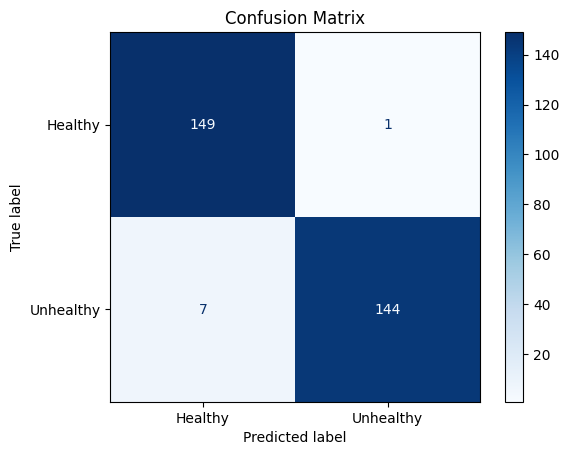

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# 1. Predict on validation set
y_pred_probs = model.predict(valid_images)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

# 2. Print classification report
print("Classification Report:\n")
print(classification_report(valid_labels, y_pred, target_names=['Healthy', 'Unhealthy']))

# 3. Plot confusion matrix
cm = confusion_matrix(valid_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Unhealthy'])

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

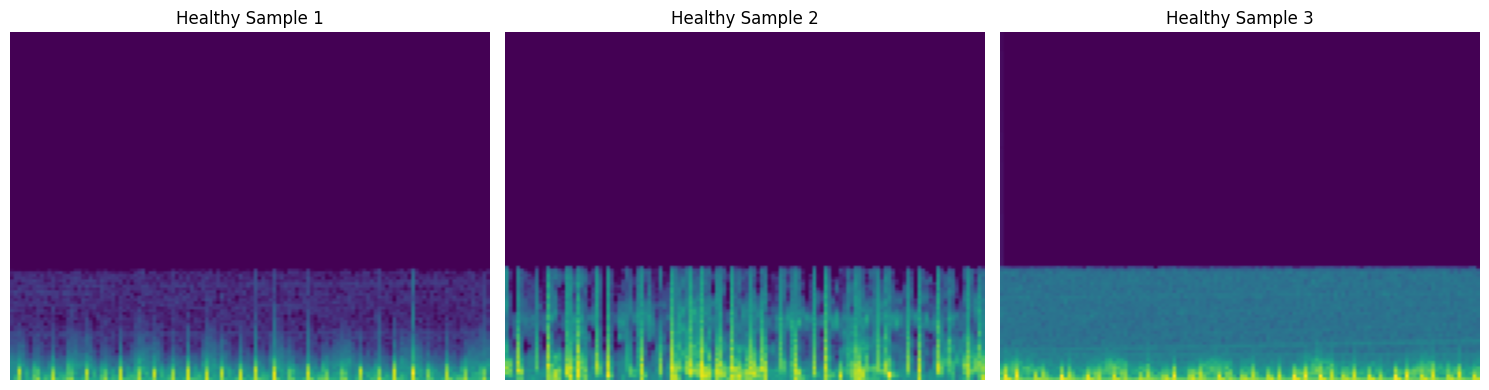

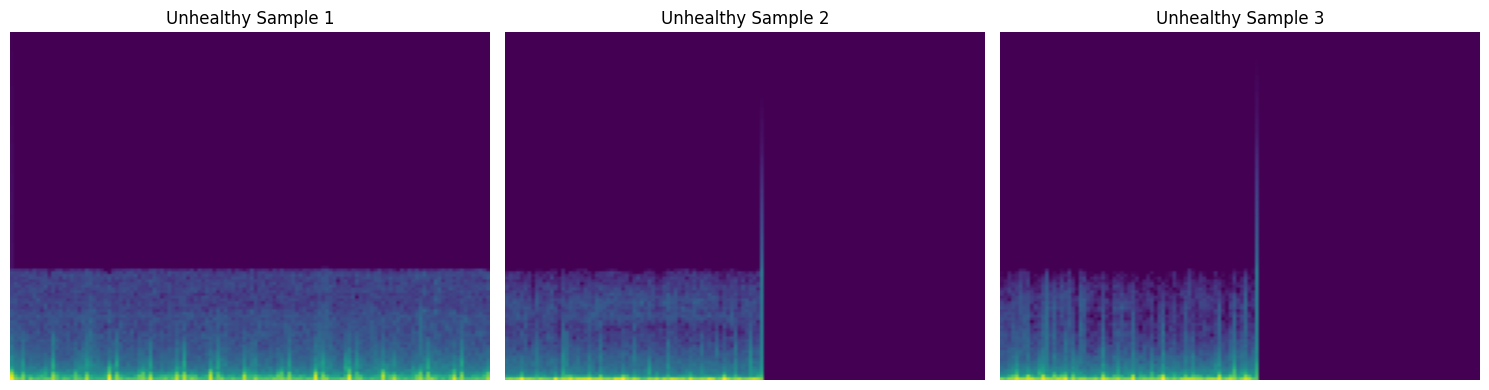

In [ ]:
import matplotlib.pyplot as plt
import random
import os
import numpy as np
from tensorflow.keras.preprocessing import image

def show_random_spectrograms(base_path, label, num=3):
    folder = os.path.join(base_path, label)
    files = random.sample(os.listdir(folder), num)

    plt.figure(figsize=(15, 4))
    for i, file_name in enumerate(files):
        img_path = os.path.join(folder, file_name)
        img = image.load_img(img_path, target_size=(128, 128), color_mode='grayscale')
        img_array = image.img_to_array(img).squeeze()

        plt.subplot(1, num, i+1)
        plt.imshow(img_array, cmap='viridis', aspect='auto')
        plt.title(f"{label.capitalize()} Sample {i+1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage:
show_random_spectrograms('/content/images_1/train', 'healthy', num=3)
show_random_spectrograms('/content/images_1/train', 'unhealthy', num=3)


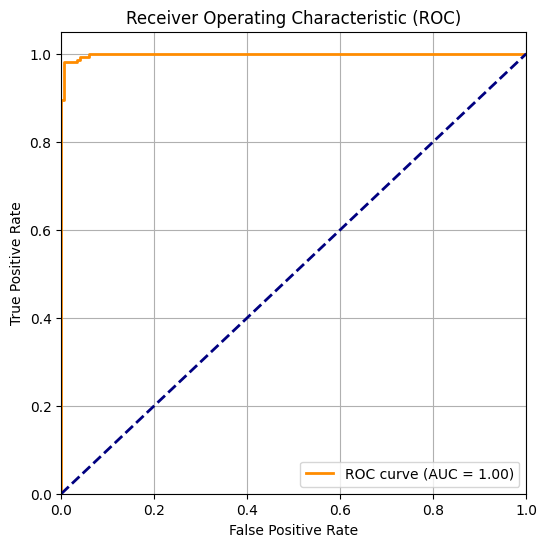

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you already have y_pred_probs and valid_labels
fpr, tpr, thresholds = roc_curve(valid_labels, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


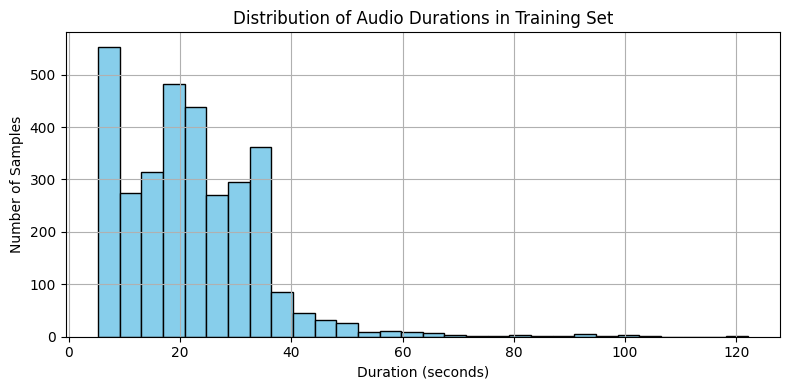

In [ ]:
import librosa
import os
import matplotlib.pyplot as plt

def get_audio_lengths(folder_path):
    durations = []
    for label in ['healthy', 'unhealthy']:
        label_path = os.path.join(folder_path, label)
        for fname in os.listdir(label_path):
            if fname.endswith('.wav'):
                y, sr = librosa.load(os.path.join(label_path, fname), sr=16000)
                durations.append(len(y) / sr)
    return durations

# Example for training set
train_durations = get_audio_lengths('/content/heart_sound/train')

# Plot histogram
plt.figure(figsize=(8, 4))
plt.hist(train_durations, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Audio Durations in Training Set')
plt.xlabel('Duration (seconds)')
plt.ylabel('Number of Samples')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
model.save('/content/model_1.h5')

In [ ]:
test_root = '/content/images_1/val'  # Make sure it contains subfolders 'healthy' and 'unhealthy'

# Loop through each label folder
for label in ['healthy', 'unhealthy']:
    folder_path = os.path.join(test_root, label)
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.wav'):
            wav_path = os.path.join(folder_path, file_name)

            # Preprocess the wav file to spectrogram
            spec = preprocess_audio_to_spectrogram(wav_path)
            spec_resized = tf.image.resize(spec, [128, 128])
            spec_resized = np.expand_dims(spec_resized, axis=0)  # Shape: (1, 128, 128, 1)

            # Predict
            prediction = model.predict(spec_resized)
            predicted_label = 'Unhealthy' if prediction[0][0] >= 0.4 else 'Healthy'

            # Print result
            print(f"{file_name} ({label}) ➜ Predicted: {predicted_label}")

In [ ]:
!apt-get install graphviz
!pip install pydot


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


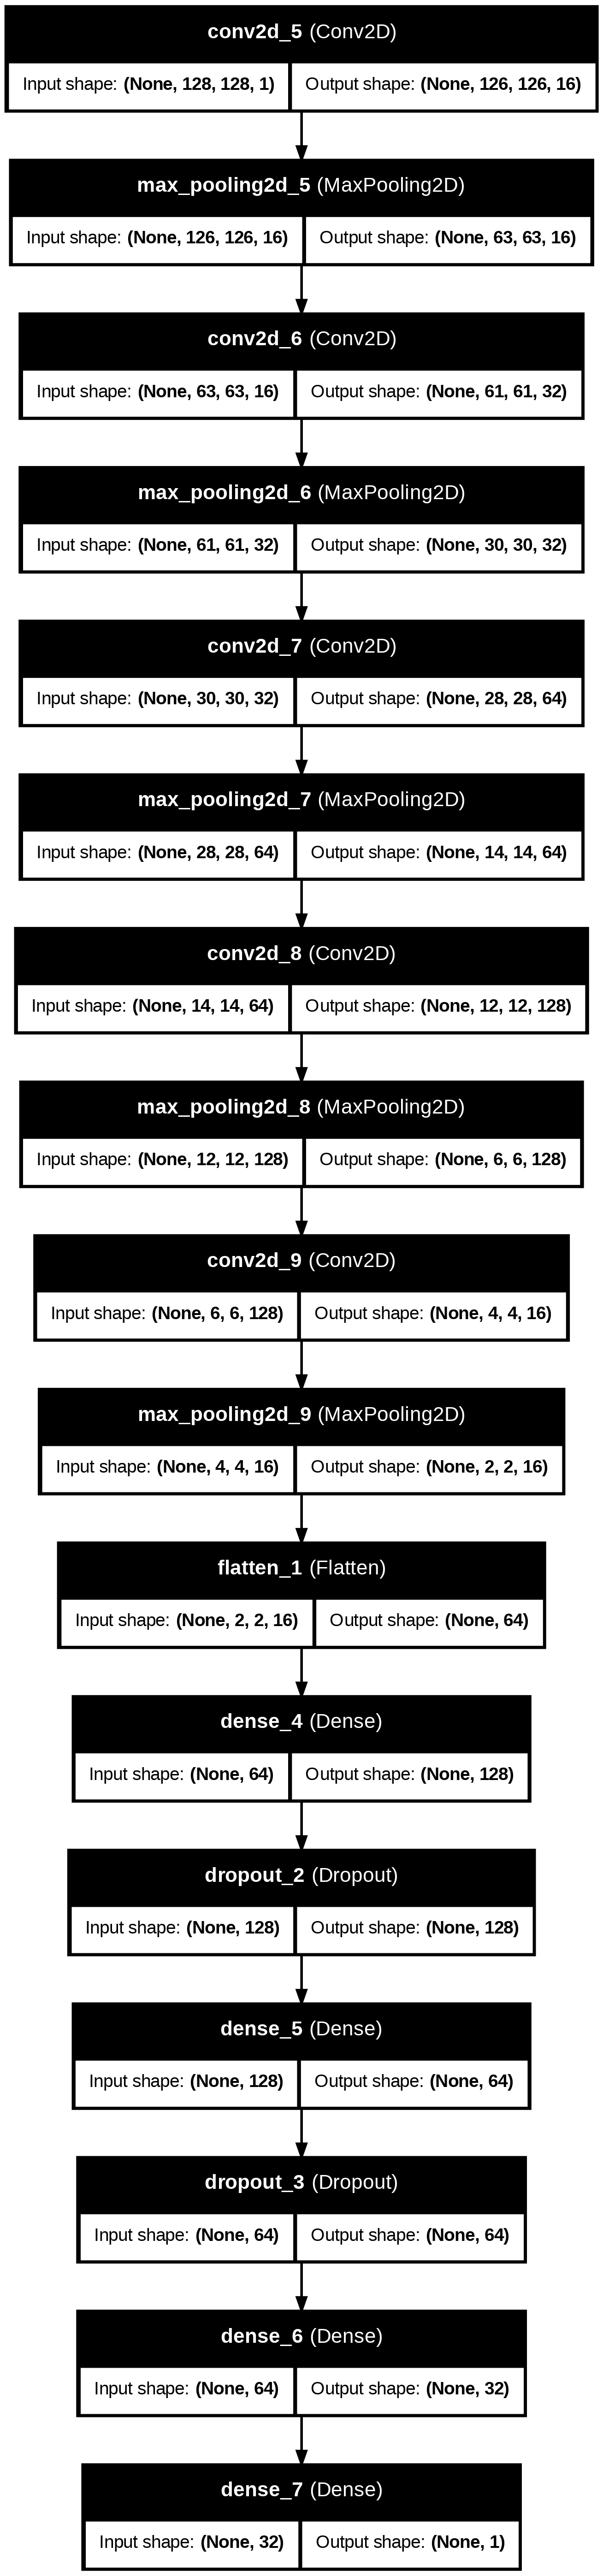

In [ ]:
from tensorflow.keras.utils import plot_model

# Save the model architecture as an image
plot_model(model, to_file='/content/model_architecture.png',
           show_shapes=True, show_layer_names=True)

#NEW EXPERIMENTS

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/work(4).zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory

In [ ]:


# Config
SAMPLE_RATE = 16000
FIXED_DURATION = 15  # seconds
FIXED_LENGTH = SAMPLE_RATE * FIXED_DURATION  # samples (8000)

def preprocess_audio_to_spectrogram(wav_path):
    y, _ = librosa.load(wav_path, sr=SAMPLE_RATE, mono=True)

    # Zero pad or truncate
    if len(y) < FIXED_LENGTH:
        padding = FIXED_LENGTH - len(y)
        y = np.pad(y, (0, padding), mode='constant')
    else:
        y = y[:FIXED_LENGTH]

    # Convert to Mel spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=SAMPLE_RATE, n_mels=128)
    S_DB = librosa.power_to_db(S, ref=np.max)

    # Normalize between 0 and 1
    S_DB = (S_DB - S_DB.min()) / (S_DB.max() - S_DB.min())

    # Add channel dimension (H, W, 1)
    # Make it ready for CNN
    S_DB = np.expand_dims(S_DB, axis=-1)

    return S_DB

def save_spectrogram_image(spec, output_path):
    plt.figure(figsize=(3, 3))
    plt.imshow(spec[:, :, 0], aspect='auto', origin='lower', cmap='viridis')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close()

# Process all files
for split in ['train', 'val']:
    input_root = f'/content/heart_sound/{split}'
    output_root = f'/content/images/{split}'

    for label in ['healthy', 'unhealthy']:
        input_folder = os.path.join(input_root, label)
        output_folder = os.path.join(output_root, label)
        os.makedirs(output_folder, exist_ok=True)

        for file_name in os.listdir(input_folder):
            if file_name.endswith('.wav'):
                wav_path = os.path.join(input_folder, file_name)
                img_path = os.path.join(output_folder, file_name.replace('.wav', '.png'))

                spectrogram = preprocess_audio_to_spectrogram(wav_path)
                save_spectrogram_image(spectrogram, img_path)


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [ ]:
# Config
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 100

# Load Images Function (already written in your code)
def load_images(image_folder):
    images = []
    labels = []

    # Loop through subfolders (healthy, unhealthy) and load images
    for label in ['healthy', 'unhealthy']:
        label_folder = os.path.join(image_folder, label)
        for img_file in os.listdir(label_folder):
            if img_file.endswith('.png'):
                img_path = os.path.join(label_folder, img_file)
                # Load image and resize it to the fixed dimensions
                img = image.load_img(img_path, target_size=IMAGE_SIZE, color_mode='grayscale')
                img_array = image.img_to_array(img)  # Convert image to array
                images.append(img_array)
                labels.append(0 if label == 'healthy' else 1)  # Assign label (0 for healthy, 1 for unhealthy)

    return np.array(images), np.array(labels)


In [ ]:
# Load data
train_images, train_labels = load_images('/content/images/train')
valid_images, valid_labels = load_images('/content/images/val')


# Normalize the image pixel values to be between 0 and 1
train_images = train_images / 255.0
valid_images = valid_images / 255.0

# Reshape images to have the correct shape for the CNN (height, width, channels)
train_images = train_images.reshape(-1, 128, 128, 1)
valid_images = valid_images.reshape(-1, 128, 128, 1)

FileNotFoundError: [Errno 2] No such file or directory: '/content/images/train/unhealthy'

In [ ]:
from tensorflow.keras.applications import MobileNetV2

from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:

# Step 3: Load base model (pretrained MobileNetV2)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze base model

# Step 4: Add custom layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Step 5: Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 6: Train model
model.fit(train_gen, validation_data=val_gen, epochs=10)

# Optional Step 7: Fine-tune last few layers of base model
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_gen, validation_data=val_gen, epochs=5)